# Image Classification model with Fastai: LSE vowels

**Source:** [Multi-label classification](https://docs.fast.ai/tutorial.vision.html#multi-label-classification)<br>
**Author:** Vanessa Alvear <br>
**Date created:** 2024/01/22<br>
**Last modified:** 2024/02/26<br>
**Description:** Training an image classifier using a pre-trained network on the vowels from the Spanish Sign Language (Lengua de Signos Española - LSE ).

# Introduction

In the next notebook, we are going to create a classification model for 5 hand gestures such as ✌ and 👌, for the vowels of the Spanish Sign Language (Lengua de Signos Española - LSE). To do so, we use the library [fastAI](https://www.fast.ai/). For the data, we create a dataset from scratch. In the next figure, we can see the signs of the vowels from LSE.

# Goal

Create an Image Classificator for the Vowels of the Spanish Sign Language (LSE). This model is going to use to integrate it with a Hand Detection model using the MediaPipe library in Python. Then, we implement a recognition system in real-time for the vowels LSE.

# Dataset: vowelsLSE

It was created on May, 2023 in the University of La Rioja. It consists of RGB images of 5 different gestures in JPG format. It contains three folders, one for training `train` (2423 images), one for testing `test` (692 images), one for validation (346 images) for a total of 3461 images. It contains 5 classes. The images can be classified into: 
  - A (332 (right hand) 335 (left hand), total images: 667)
  - E (377 (right hand) 393 (left hand), total images: 770)
  - I (333 (right hand) 335 (left hand), total images: 668)
  - O (340 (right hand) 338 (left hand), total images: 678)
  - U (334 (right hand) 344 (left hand), total images: 678)
  
The images are 400 x 400 in size and have a white background so that they are the same size.

**Observation:** Here we are going to mention the test dataset as **Original test data**.

In [1]:
from PIL import Image

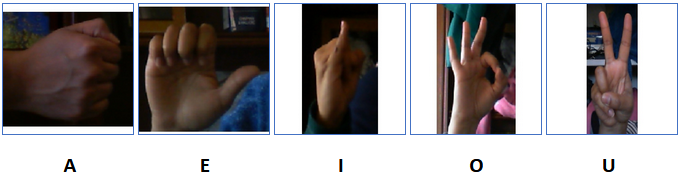

In [2]:
Image.open("images/vowels-lse-1.png")

# New dataset for test

## Dataset: vowelsLSE_new_test

It was created on Jan, 2024 in the University of La Rioja. It consists of RGB images of 5 different gestures in JPG format from five different people in different days, and in this data there is not information of the person who created the train dataset. This folder contains two subfolders, one for testing `test` (197 images), and the other one for `train` which is the same than the previous dataset. We collected a total of 197 images where it can be classified into: 

  - A (21 (right hand) 21 (left hand), total images: 42)
  - E (22 (right hand) 15 (left hand), total images: 37)
  - I (21 (right hand) 20 (left hand), total images: 41)
  - O (18 (right hand) 20 (left hand), total images: 38)
  - U (21 (right hand) 18 (left hand), total images: 39)
  
The images are 400 x 400 in size. They have a white background to make them in the same size and this process was made in local.

**Observation:** The `train` folder here, has the same images that the dataset vowelsLSE, a total of 2423 images. This might be added to this folder, because when we are creating the `DataBlock` structure for the data provided it in the `DataLoader`, we use an object of class `GrandparentSplitter` there is necessary gives the partition of the dataset in train and test, to be selected the `test` data, in our case.

**Observation:** Here we are going to mention the test dataset as **New test data**.

# Libraries

We import the necessary libraries 

We define the GPU to be used

In [3]:
%env CUDA_VISIBLE_DEVICES = 3

env: CUDA_VISIBLE_DEVICES=3


In [4]:
from fastai.vision.all import *
import fastai

In [5]:
fastai.__version__

'2.7.12'

In [6]:
seed = 1234

In [7]:
#Split dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import shutil
import random

import os
import numpy as np

import seaborn as sns

from sklearn.metrics import accuracy_score

In [8]:
import timm

# Functions

In [9]:
def dataframeAllvowels(path_src, classes):
    """
    Creates a dataframe with the filename list, and name the column as 'photo_name'.
    Parameters:
    path_src: directory string for data.
    classes: list of subdirectory names.
    """
    list1 = []
    for i in classes:
        imagePath = os.path.join(path_src, str(i)+'/')
        list_imagePath = [entry for entry in os.listdir(imagePath) if os.path.isfile(os.path.join(imagePath, entry))]
        df_ = pd.DataFrame(list_imagePath, columns = ['photo_name'])
        list1.append(df_)
        df = pd.concat(list1)
    return df 


In [10]:
def countFilesPath(path, classNames, path_name):
    """
    Count total files in a path per subfolder
    Parameters:
    path: directory string for data.
    classNames: list of subdirectory names.
    path_name: name to print the source directories. Any string.
    """    
    for i in classNames:
        print("Number of files "+ path_name + str(i) +" =", len([entry for entry in os.listdir(path+'/'+ str(i)) if os.path.isfile(os.path.join(path+'/'+ str(i), entry))]))

In [11]:
def findCorruptedImages(path):
    """
    Count total corrupted files in a path per subfolder, if the image is not JPG format
    Parameters:
    path: directory string for data.
    """     
    for k in path:
        for filename in os.listdir(path):
            if filename.endswith('.JPG'):
                try:
                    img=Image.open(path+filename)
                    img.verify()
                except(IOError,SyntaxError)as e:
                    print('Bad file  :  '+filename)
                    count=count+1
                    print(count)

In [12]:
def prediction(model, image_list):
    """
    Predictions by a list of image according specific model
    Parameters:
    model: model trained
    image_list: list of image names    
    """   
    return [model.predict(i) for i in image_list]

In [13]:
def model_prediction(model):
    model.dls = dlsTest
    pred = model.get_preds()[0]
    return pred

In [14]:
def list_file_names(origin_path):
    l = []
    for path, subdirs, files in os.walk(origin_path):
        for name in files:
            full_path = os.path.join(path, name)
            l.append(full_path)
    return l  # (os.path.join(path, name))

In [15]:
def print_duplicate_filenames(path):
    path_dict = {}
    for i in glob.iglob(path,recursive =True):
        if i in path_dict:
            print(i)
        else:
            path_dict[i] = 1

In [16]:
def has_duplicates2(seq):
    seen = []
    unique_list = [x for x in seq if x not in seen and not seen.append(x)]
    return len(seq) != len(unique_list)

# Info Dataset

Defining classes and paths

In [17]:
full_path = 'vowels_lse_new_data_fastai'
trainPath_st = 'vowels_lse_new_data_fastai/train'
testPath_st = 'vowels_lse_new_data_fastai/test'

In [18]:
path = Path(full_path)

Now we have two folders `train, test` which contains five subfolders, `A, E, I, O`,  and `U`. Each subfolder has image files for each category.

We can create `path` objects that point respectively to the training set and the test set. 

Functions such as ls() can be used with the path object.

In [19]:
trainPath = Path(trainPath_st)
testPath = Path(testPath_st)

We can see that both the `train` folder and the `test` folder contain 5 subfolders, one for each class.

In [20]:
trainPath.ls()

(#5) [Path('vowels_lse_new_data_fastai/train/I'),Path('vowels_lse_new_data_fastai/train/O'),Path('vowels_lse_new_data_fastai/train/U'),Path('vowels_lse_new_data_fastai/train/A'),Path('vowels_lse_new_data_fastai/train/E')]

In [21]:
testPath.ls()

(#5) [Path('vowels_lse_new_data_fastai/test/I'),Path('vowels_lse_new_data_fastai/test/O'),Path('vowels_lse_new_data_fastai/test/U'),Path('vowels_lse_new_data_fastai/test/A'),Path('vowels_lse_new_data_fastai/test/E')]

These are the classes names for the vowels

In [22]:
class_names = ['A', 'E', 'I', 'O', 'U']

Creating a dataframe to see if there are duplicated images

In [23]:
df_train = dataframeAllvowels(trainPath_st, class_names)

In [24]:
df_test = dataframeAllvowels(testPath_st, class_names)

In [25]:
frames = [df_train, df_test]
df = pd.concat(frames)

In [26]:
df.head(3)

,photo_name
0,Image_1683206533.9086118.jpg
1,Image_1683273927.5380101.jpg
2,Image_1683208740.7728174.jpg


In [27]:
df.shape

(3461, 1)

In [28]:
df.duplicated(keep=False).sum()

0

There is no dupplicated data putting all images together.

We can count the number of files in each path

In [29]:
countFilesPath(trainPath_st, class_names, "trainPath_")

Number of files trainPath_A = 534
Number of files trainPath_E = 616
Number of files trainPath_I = 535
Number of files trainPath_O = 542
Number of files trainPath_U = 542


In [30]:
countFilesPath(testPath_st, class_names, "testPath_")

Number of files testPath_A = 133
Number of files testPath_E = 154
Number of files testPath_I = 133
Number of files testPath_O = 136
Number of files testPath_U = 136


Finding corrupted data

In [31]:
findCorruptedImages(trainPath_st)

# Model: ViT base 32

## Loading the dataset

The dataset is loaded so that the model can be created later. This process is done in two steps. First a `DataBlock` object is constructed and then a `DataLoader` object is constructed from the `DataBlock`.

### Datablock

To start, the `DataBlock` object is constructed. 

Since there is a training set and a test set, the validation set is randomly taken from the training set using 10% of the training set. In addition, a prescaling technique and a data augmentation technique are applied.

Here, it is important normalize data according to the values from ImageNet. These are the mean, and standard deviation from RGB images.

In [32]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [33]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
               get_items=get_image_files, 
               splitter=RandomSplitter(valid_pct=0.1, seed=seed),
               get_y=parent_label,
               item_tfms = Resize(256),
               batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=False,
                  max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                         Normalize.from_stats(*imagenet_stats)]) 

In the `DataBlock` object we can see that it takes as input value images and the output is the category of each of the images. In the presizing technique is considered by default the method of type ResizeMethod whose default technique is 'crop', this technique takes the images and applies this transformation to randomly crop the images to size 256. Furthermore, in the presizing, the pad_mode of type PadMode is considered whose default value is the 'reflection' technique, this technique reflects the images vertically. 

Additionally, in the data augmentation technique we have the following default transformations are applied:

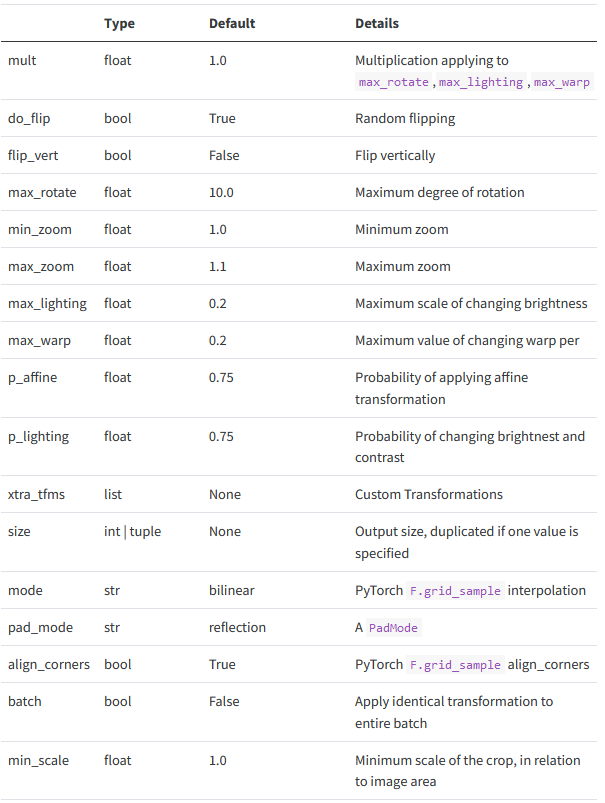

In [34]:
Image.open("images/transformations_aug_aumentation.png")

In the data enhancement technique we observe that among the transformations applied to the images we can find: rotations, flipping the images in random directions, zooming, warping the images, brightness and [affine transformations](https://en.wikipedia.org/wiki/Affine_transformation) (a geometric transformation that preserves lines and parallelism - but not necessarily distances and angles). 

### Dataloader

Now, the next step is to build the `DataLoader` which is built from the `DataBlock` previously built, indicating the path where the images are located. In addition, we indicate the size of the batch we want to use.

In [35]:
dls = db.dataloaders(trainPath, bs=16) #bs: batch size

A batch of the `DataLoader` is shown below. It is convenient to check that the images and their annotations have really been loaded correctly.

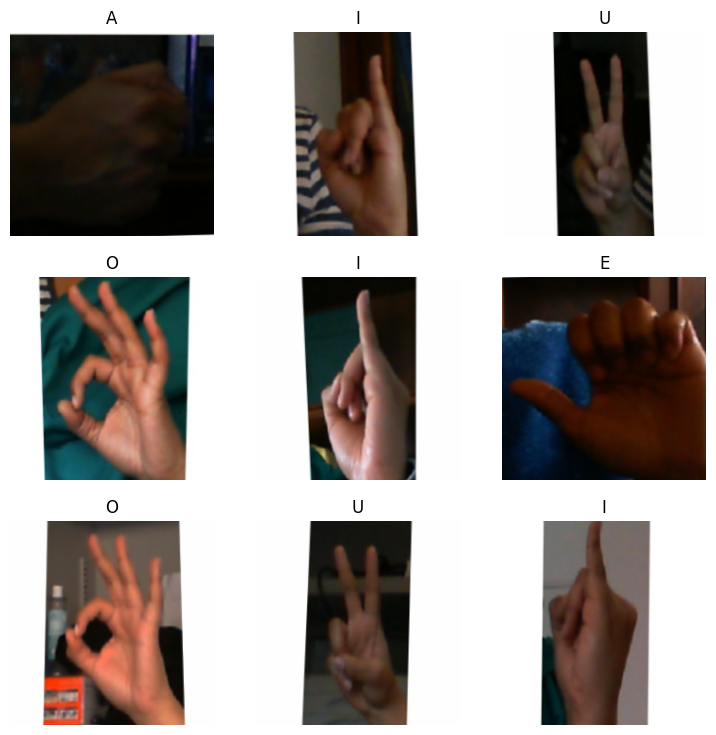

In [36]:
dls.show_batch()

## Training the model 

The next step is to build and train the model. But first, a series of *callbacks* are defined.

We are going to use 3 callbacks:

- ShowGraphCallback. 
- EarlyStoppingCallback. 
- SaveModelCallback. 

With this you want to:

- Show the training and validation curves. 
- It allows to apply the early stopping technique. You must indicate the metric you want to monitor to know when to stop, and the patience (i.e. how many epochs you let the model continue training if there has been no improvement). 
- The best model found during the training process is saved and loaded at the end of the training process.

A model is to be created using the ViT base 32 architecture and this should be indicated in the model name.

In [37]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3), #Patiente depende del número de épocas
    SaveModelCallback(fname='model_vit_interaction')  
]

In addition to these three callbacks, another callback will be used to accelerate the training of the models using [*mixed precision*], this callback is indicated differently as shown below.

## Building the model

Next we build the model, an object of the `Learner` class, using the `cnn_learner` method that takes as parameters the `DataLoader`, the architecture to be trained (in this case a `resnet50`), the metric to be used to evaluate our model (this evaluation is done on the validation set, and in our case it will be the *accuracy*), and the callbacks. Note that in the previous instruction we include the transformation of the model to *mixed precision* by means of the instruction ``to_fp16``.

In [38]:
learn = Learner(dls,timm.create_model("vit_base_patch32_224", num_classes=5, pretrained=True),
                metrics=accuracy, cbs=callbacks).to_fp16()

Note that internally the `vision_learner` function does several things with the architecture that we pass as parameter (in this case `resnet50`). This architecture was initially trained for the ImageNet problem, so when faced with a new image, its output would be the prediction in one of the 1000 ImageNet classes. However, internally the `vision_learner` function removes the last layers of that architecture, and replaces them with one suitable for our particular problem. 

Before training our model we must find a suitable *learning rate*. 

### Learning rate finder

We found with the `lr_find()` function the learning rate.

SuggestedLRs(valley=2.511886486900039e-05)

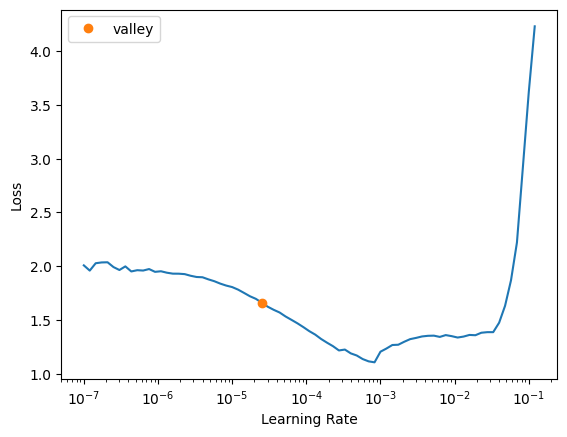

In [39]:
learn.lr_find()

In this case, we are finding the learning rate of the model that we have built, for this, we modify the weights of our network with the objective of learning the model to find the minimum value in which the error has been reduced so that it is not the global minimum (it could not be the global minimum because it would indicate that the model at that value is no longer learning). The value found for the learning rate is 1e-5.

### Fine-tuning

Next we are going to apply the technique of *fine tuning*. In FastAI this is as simple as calling the `fine_tune` method of the `Learner` object. This method receives two main parameters, the number of epochs (20 in our case) and the learning rate. The process it follows to train consists of:
1. Freeze all layers except the last one, and train that part of the model for one epoch.
2. Defrost the network, and train the model for the indicated number of epochs. 

We will see a table where you can see the loss for the training set, the loss for the validation set, and the accuracy for the validation set. 

In [41]:
# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

now = 2024-02-22 20:05:20.057312
date and time = 22/02/2024 20:05:20


epoch,train_loss,valid_loss,accuracy,time
0,0.450947,0.173111,0.960145,00:18


Better model found at epoch 0 with valid_loss value: 0.17311112582683563.


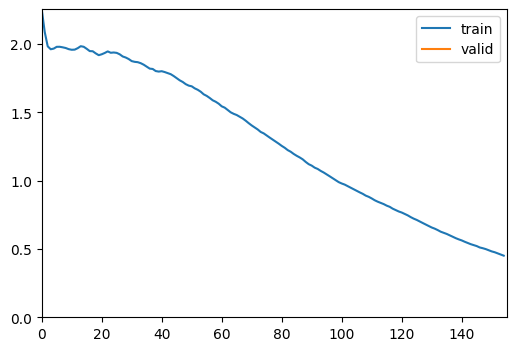

epoch,train_loss,valid_loss,accuracy,time
0,0.060652,0.083075,0.981884,00:17
1,0.032947,0.044330,0.992754,00:17
2,0.013077,0.024748,0.996377,00:17
3,0.005543,0.016059,0.996377,00:18
4,0.003802,0.016797,0.996377,00:16
5,0.004768,0.015680,0.996377,00:18
6,0.002787,0.016500,0.996377,00:19
7,0.001053,0.014628,0.996377,00:19
8,0.000408,0.014026,0.996377,00:19
9,0.000340,0.014641,0.996377,00:17


Better model found at epoch 0 with valid_loss value: 0.08307456225156784.


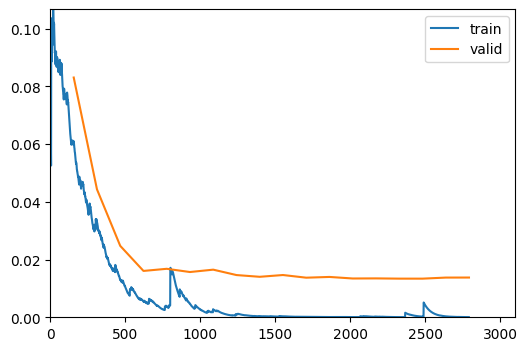

Better model found at epoch 1 with valid_loss value: 0.044329654425382614.
Better model found at epoch 2 with valid_loss value: 0.02474847249686718.
Better model found at epoch 3 with valid_loss value: 0.01605943590402603.
Better model found at epoch 5 with valid_loss value: 0.015679633244872093.
Better model found at epoch 7 with valid_loss value: 0.014628064818680286.
Better model found at epoch 8 with valid_loss value: 0.014025751501321793.
Better model found at epoch 10 with valid_loss value: 0.013718204572796822.
Better model found at epoch 12 with valid_loss value: 0.013439071364700794.
Better model found at epoch 14 with valid_loss value: 0.013389349915087223.
Better model found at epoch 15 with valid_loss value: 0.013384156860411167.
No improvement since epoch 15: early stopping


In [42]:
learn.fine_tune(20, base_lr=1e-5) 

In [43]:
# datetime object containing current date and time
now1 = datetime.now()
 
print("now =", now1)

# dd/mm/YY H:M:S
dt_string1 = now1.strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string1)

now = 2024-02-22 20:12:14.809047
date and time = 22/02/2024 20:12:14


In [44]:
tdelta = now1 - now 

In [45]:
tdelta

datetime.timedelta(seconds=414, microseconds=751735)

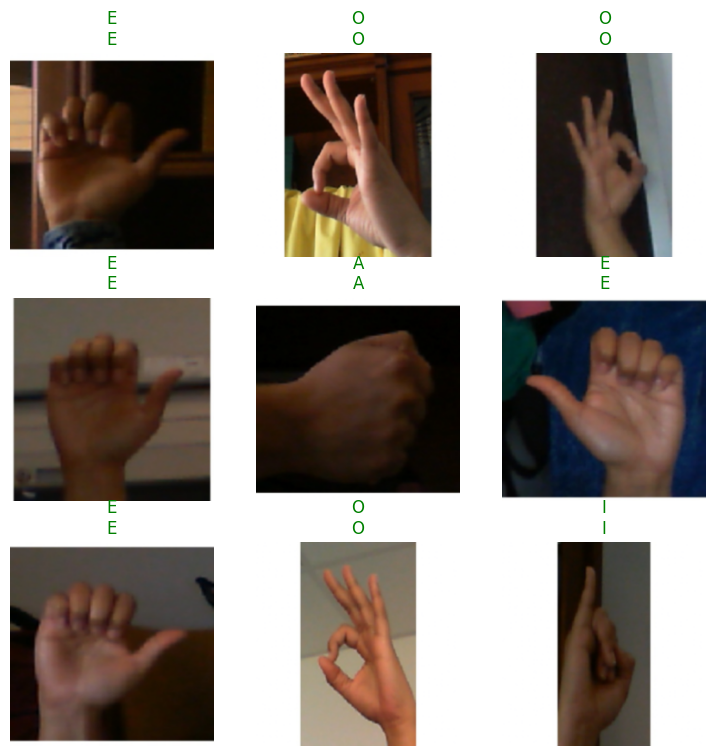

In [46]:
learn.show_results()

At the end of the training a model has been saved in the `models` folder containing the best model built.

In [47]:
Path('models').ls()

(#6) [Path('models/.ipynb_checkpoints'),Path('models/modelResnet50_interaction.pth'),Path('models/model_vit_b_16_interaction.pth'),Path('models/modelResnet18.pth'),Path('models/model_vit_interaction.pth'),Path('models/modelResnet50.pth')]

For further use, it is convenient to export the model. To do this, it is first necessary to convert the model to fp32.

In [48]:
learn.to_fp32()
learn.export('export_vit_b_32_model.pkl')

We can see that this model has been saved in the same directory where we are. 

In [49]:
Path().ls(file_exts='.pkl')

(#4) [Path('export_vit_b_32_model.pkl'),Path('export_vit_model.pkl'),Path('export_resnet50.pkl'),Path('export_resnet.pkl')]

### Evaluation on the validation set

In [50]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.9963768124580383.


(#2) [0.01340542919933796,0.9963768124580383]

## Evaluating the model

### Evaluating the model on the test suite

In order to evaluate our model in the test set we must create a new `DataBlock` and a new `DataLoader`. The only difference with the `DataBlock` previously used is that to partition the dataset we use an object of class `GrandparentSplitter` indicating that the validation set is our test set. In the case of the `DataLoader`, the difference with the previously defined is that we change the path to the path. 

In [51]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
            get_items=get_image_files, 
            splitter= GrandparentSplitter(valid_name='test'), #Usamos el conjunto de test
            get_y=parent_label,
            item_tfms = Resize(256),
            batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=False,
            max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                    Normalize.from_stats(*imagenet_stats)])

In [52]:
dlsTest = dbTest.dataloaders(path, bs=128)

To work with this dataloader we must modify our `Learner` object. Specifically its `dls` attribute. 

In [53]:
learn.dls = dlsTest

Now we can evaluate our model using the `validate` method.

In [54]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.9971098303794861.


(#2) [0.005351086147129536,0.9971098303794861]

The `validate` method returns two values: the value of the loss function, and the value of our metric (the accuracy in this case). So we can see that the model has an accuracy in the test set of approximately 99.71% (this may vary depending on the execution). 

### Model interpretation

We have seen that our model obtains an approximate accuracy (it may vary due to the randomness of the training process) of 99.71% on the test set. But we are interested in knowing the errors that are made and if they are reasonable. To do this we can construct a `ClassificationInterpretation` object from our `Learner` and display the associated confusion matrix. Remember that we have changed the DataLoader in the previous step, because it is convenient to return to the dataloader used initially.

In [55]:
learn.dls=dls

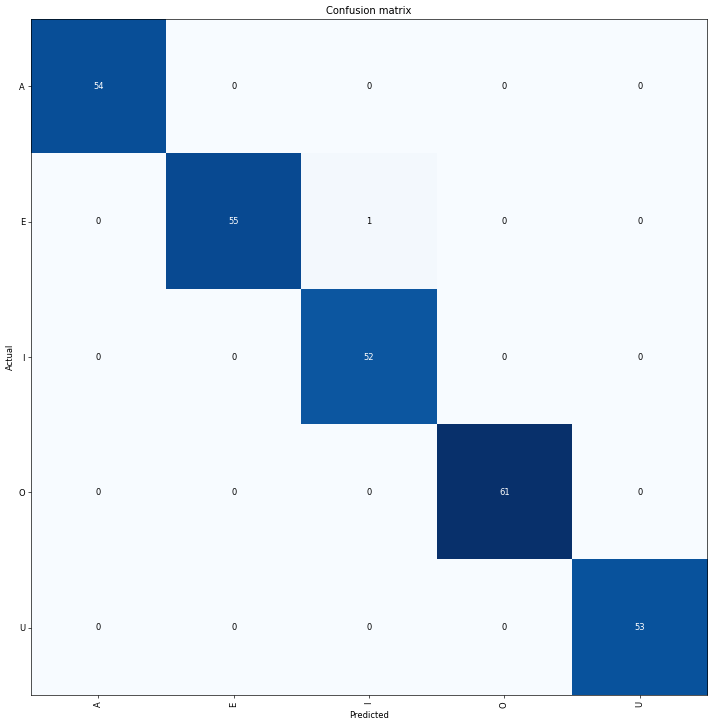

In [56]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

We can analyze, the error that happens when the model confuses one image of the `E` class to the `I` class. 

In the following images, we can see samples of the resulting classifications, above the correct classification and, below the prediction.

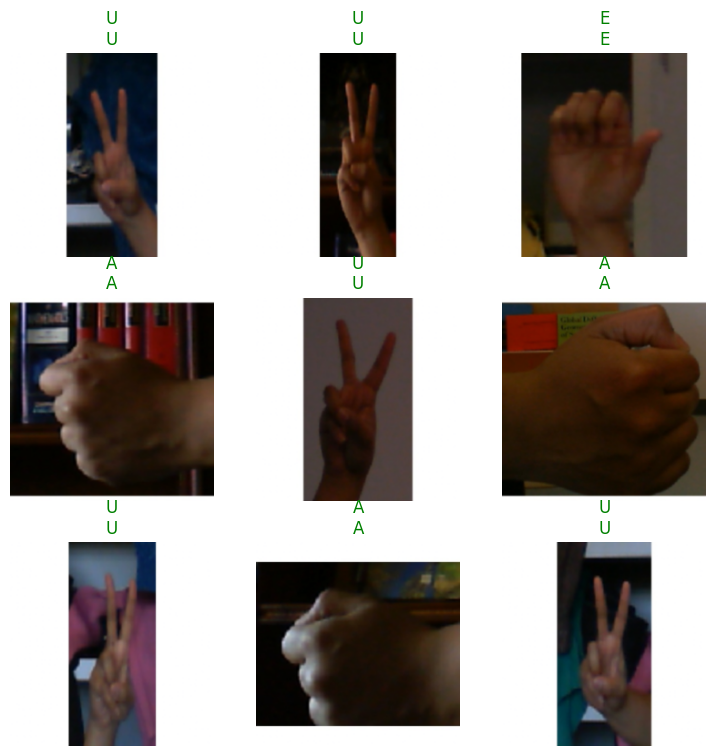

In [57]:
learn.show_results()

In particular, we can see the prediction, actual classification, the values of the loss function and the probability, in the first place the case where was not correct and the others, where is correct.

In [59]:
interp2 = Interpretation.from_learner(learn)

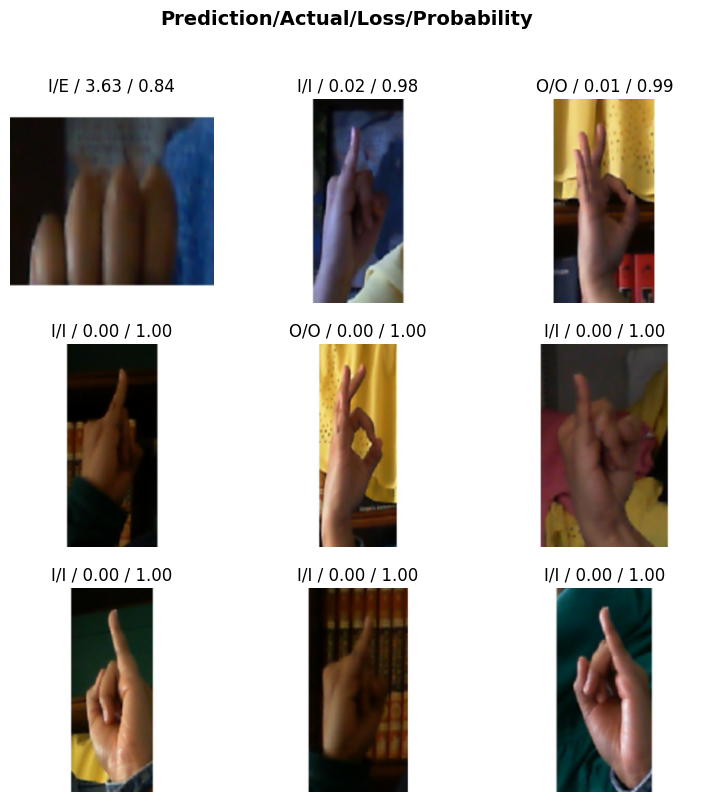

In [60]:
interp2.plot_top_losses(9)

In addition, we applied the test time augmentation technique(tta) to improve model performance

In [61]:
preds,gt=learn.tta()

In [62]:
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(preds,axis=1),gt)

0.9963768115942029

It improve as much as we expected.

### Using the model

Let's see how to use the model in front of a new image. The first thing we are going to do is to load the model. 

In [63]:
learn_inf = load_learner('export_vit_b_32_model.pkl')

Using the `predict` method, we can use this model to make inferences with a new image. In our case, we will use an image from the test set. 

In [64]:
learn_inf.predict("otras_imagenes_inferencia/a_otros1.jpg")

('A',
 tensor(0),
 tensor([9.9998e-01, 2.0689e-06, 1.1445e-05, 6.2648e-06, 2.3031e-06]))

The above function returns five values:
- The class (*A* in this case).
- The index associated with that class. 
- The probabilities for each of the categories.  

We can predict on various images 

In [65]:
def prediction(image_list):
    return [learn_inf.predict(i) for i in image_list]

New images with the same person which build the dataset

In [66]:
# These are the images with size (1280,720)
other_image_list = ["otras_imagenes_inferencia/a_otros1.jpg", "otras_imagenes_inferencia/e_otros1.jpg", "otras_imagenes_inferencia/i_otros1.jpg", "otras_imagenes_inferencia/o_otros1.jpg", "otras_imagenes_inferencia/u_otros1.jpg"]

In [67]:
prediction(other_image_list)

[('A',
  tensor(0),
  tensor([9.9998e-01, 2.0689e-06, 1.1445e-05, 6.2648e-06, 2.3031e-06])),
 ('E',
  tensor(1),
  tensor([1.5990e-05, 9.9892e-01, 1.4292e-05, 1.0103e-03, 4.3534e-05])),
 ('I',
  tensor(2),
  tensor([8.0202e-06, 1.4613e-05, 9.9989e-01, 2.8508e-05, 5.7065e-05])),
 ('O',
  tensor(3),
  tensor([2.3788e-06, 6.3845e-06, 1.7898e-06, 9.9988e-01, 1.1176e-04])),
 ('U',
  tensor(4),
  tensor([4.4123e-05, 4.9245e-06, 7.5918e-06, 9.1030e-04, 9.9903e-01]))]

Test images

In [68]:
# These are the images from test set with size (300, 300)
test_image_list = ["images/a_test.jpg", "images/e_test.jpg", "images/i_test.jpg", "images/o_test.jpg", "images/u_test.jpg"]

In [69]:
prediction(test_image_list)

[('A',
  tensor(0),
  tensor([1.0000e+00, 1.0192e-06, 1.1453e-06, 6.1881e-07, 1.8750e-06])),
 ('E',
  tensor(1),
  tensor([1.3083e-06, 9.9999e-01, 4.1692e-06, 1.1392e-06, 2.4908e-06])),
 ('I',
  tensor(2),
  tensor([2.2684e-06, 7.0831e-06, 9.9997e-01, 1.1131e-05, 1.2811e-05])),
 ('O',
  tensor(3),
  tensor([7.2295e-04, 1.5681e-04, 5.2301e-06, 9.9911e-01, 6.8930e-06])),
 ('U',
  tensor(4),
  tensor([4.4908e-06, 4.2623e-06, 3.4332e-06, 7.7190e-06, 9.9998e-01]))]

# Evaluation on New Images for test

In [70]:
# !cp -R vowels_crop_hands/test vowels_crop_hands/train

In [71]:
path_crop_data = Path('vowels_crop_hands/')

In [72]:
path_crop_data

Path('vowels_crop_hands')

In [73]:
os.listdir(path_crop_data)

['train', 'test']

In [75]:
# shutil.rmtree('vowels_crop_hands' + '/.ipynb_checkpoints')

In [74]:
os.listdir(path_crop_data)

['train', 'test']

In [75]:
get_image_files(path_crop_data)

(#394) [Path('vowels_crop_hands/train/I/Image_person4 (9).jpg.jpg'),Path('vowels_crop_hands/train/I/Image_person2 (5).jpg.jpg'),Path('vowels_crop_hands/train/I/Image_person4 (5).jpg.jpg'),Path('vowels_crop_hands/train/I/Image_person4 (3).jpg.jpg'),Path('vowels_crop_hands/train/I/Image_person1 (8).jpg.jpg'),Path('vowels_crop_hands/train/I/Image_person1 (1).jpg.jpg'),Path('vowels_crop_hands/train/I/Image_person2 (12).jpg.jpg'),Path('vowels_crop_hands/train/I/Image_person5 (8).jpg.jpg'),Path('vowels_crop_hands/train/I/Image_person5 (5).jpg.jpg'),Path('vowels_crop_hands/train/I/Image_person4 (4).jpg.jpg')...]

In [76]:
parent_label(get_image_files(path_crop_data)[0])

'I'

In [77]:
dbTest_crop = DataBlock(blocks = (ImageBlock, CategoryBlock),
            get_items=get_image_files, 
            splitter=GrandparentSplitter(valid_name='test'), #Usamos el conjunto de test
            get_y=parent_label,
            item_tfms = Resize(256),
            batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=False,
            max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                Normalize.from_stats(*imagenet_stats)])

In [78]:
os.listdir(path_crop_data/'test')

['I', 'O', 'U', 'A', 'E']

In [79]:
#shutil.rmtree('vowels_crop_hands/test' + '/.ipynb_checkpoints')

In [80]:
#os.listdir(path_crop_data/'test')

In [81]:
dlsTest_crop = dbTest_crop.dataloaders(path_crop_data, bs=16)

To work with this dataloader we must modify our `Learner` object. Specifically its `dls` attribute. 

In [82]:
learn_inf.dls = dlsTest_crop

Now we can evaluate our model using the `validate` method.

In [83]:
learn_inf.validate()

Better model found at epoch 0 with valid_loss value: 0.8578680157661438.


(#2) [0.40277695655822754,0.8578680157661438]

The `validate` method returns two values: the value of the loss function, and the value of our metric (the accuracy in this case). So we can see that the model has an accuracy in the test set of approximately 85.78% (this may vary depending on the execution). 

### Model interpretation

We have seen that our model obtains an approximate accuracy (it may vary due to the randomness of the training process) of 85.78% on the test set. But we are interested in knowing the errors that are made and if they are reasonable. To do this we can construct a `ClassificationInterpretation` object from our `Learner` and display the associated confusion matrix. Remember that we have changed the DataLoader in the previous step, because it is convenient to return to the dataloader used initially.

In [50]:
#learn_inf.dls=dls

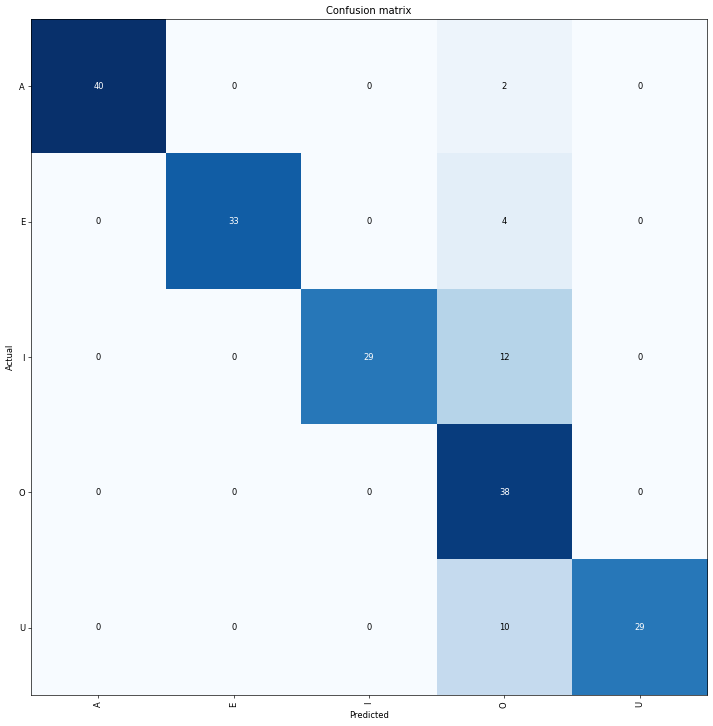

In [84]:
interp = ClassificationInterpretation.from_learner(learn_inf)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

We can analyze, the error that happens when the model confuse at least one image of each vowel as the `O` class. Most commonly confuse class `I` as the `O` class.

In the following images, we can see samples of the resulting classifications, above the correct classification and, below the prediction.

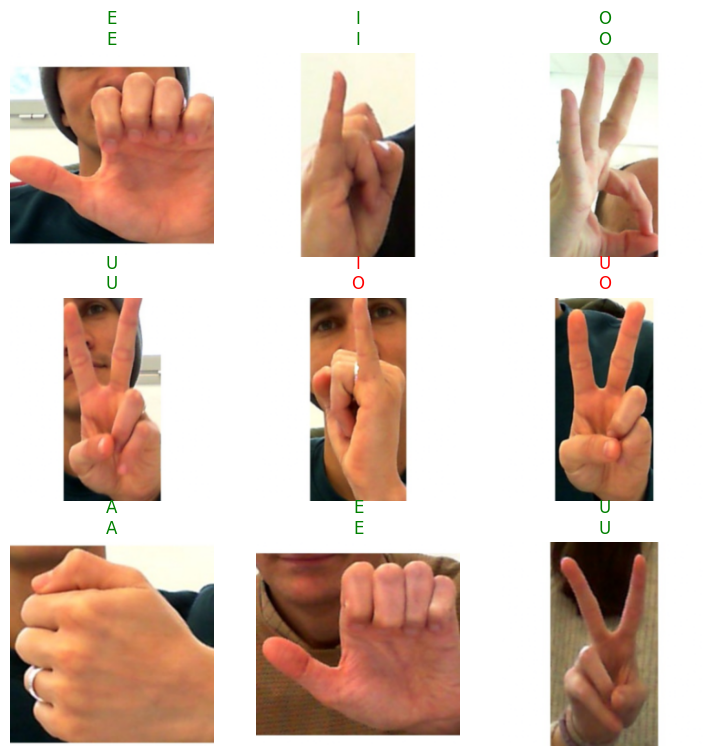

In [85]:
learn_inf.show_results()

In particular, we can see the prediction, actual classification, the values of the loss function and the probability, in the first place the case where was not correct and the others, where is correct.

In [86]:
interp3 = Interpretation.from_learner(learn_inf)

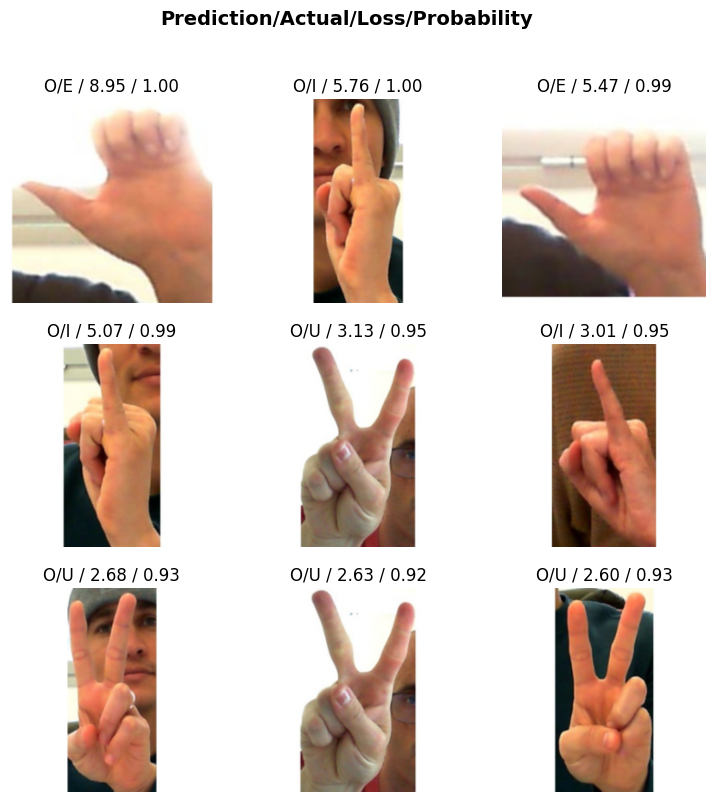

In [87]:
interp3.plot_top_losses(9)

In addition, we applied the test time augmentation technique(tta) to improve model performance

In [88]:
preds3,gt3=learn_inf.tta()

In [89]:
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(preds3,axis=1),gt3)

0.9086294416243654

The tta technique improves our results to 90.86% without tta. 

Even though the tta technique does not improve our results, the best accuracy was 99.71%, nevertheless, we achieved a test accuracy for unknown data from different people for 90.86%.

## Sources and References

Some additional references that allowed this work to be carried out

1. Affine transformations: https://en.wikipedia.org/wiki/Affine_transformation

2. Presizing and aug_aumentation: https://docs.fast.ai/vision.augment#aug_transforms